Pandemic Flu Spread Simulation and Analysis

ISYE_6644 Pandemic Flu Spread Simulation

Simulation completed without immunization.
Pandemic Duration: Mean = 11.47, 95% Confidence Interval = (11.02, 11.93)


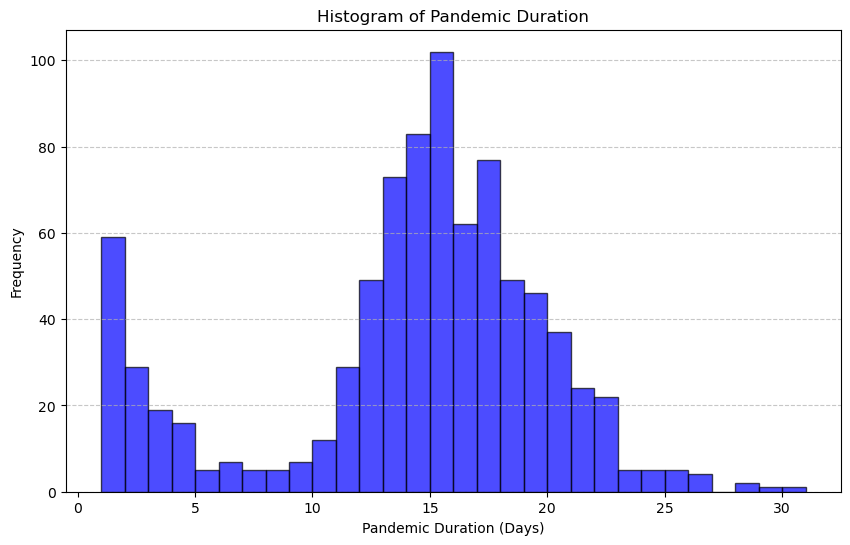

Day 1: Mean Infections = 0.58, 95% Confidence Interval = (0.54, 0.63)
Day 2: Mean Infections = 0.92, 95% Confidence Interval = (0.86, 0.99)
Day 3: Mean Infections = 1.42, 95% Confidence Interval = (1.33, 1.51)
Day 4: Mean Infections = 1.57, 95% Confidence Interval = (1.46, 1.68)
Day 5: Mean Infections = 1.92, 95% Confidence Interval = (1.79, 2.05)
Day 6: Mean Infections = 2.31, 95% Confidence Interval = (2.16, 2.46)
Day 7: Mean Infections = 2.33, 95% Confidence Interval = (2.18, 2.47)
Day 8: Mean Infections = 2.58, 95% Confidence Interval = (2.42, 2.73)
Day 9: Mean Infections = 2.47, 95% Confidence Interval = (2.32, 2.62)
Day 10: Mean Infections = 2.31, 95% Confidence Interval = (2.16, 2.45)
Day 11: Mean Infections = 2.13, 95% Confidence Interval = (2.00, 2.27)
Day 12: Mean Infections = 1.86, 95% Confidence Interval = (1.74, 1.98)
Day 13: Mean Infections = 1.61, 95% Confidence Interval = (1.50, 1.72)
Day 14: Mean Infections = 1.31, 95% Confidence Interval = (1.21, 1.42)
Day 15: Mean In

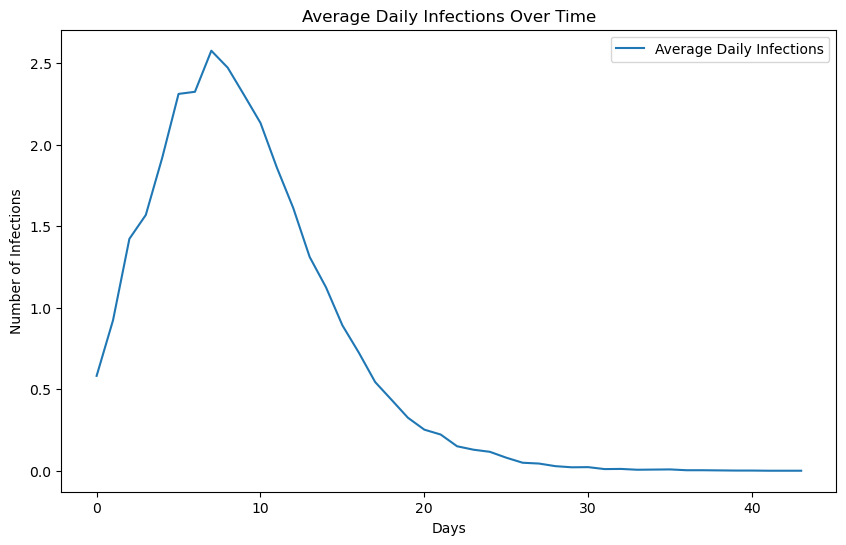


Conducting sensitivity analysis for p_infection...
Testing p_infection = 0.005...
Testing p_infection = 0.01...
Testing p_infection = 0.02...
Testing p_infection = 0.05...
Testing p_infection = 0.1...


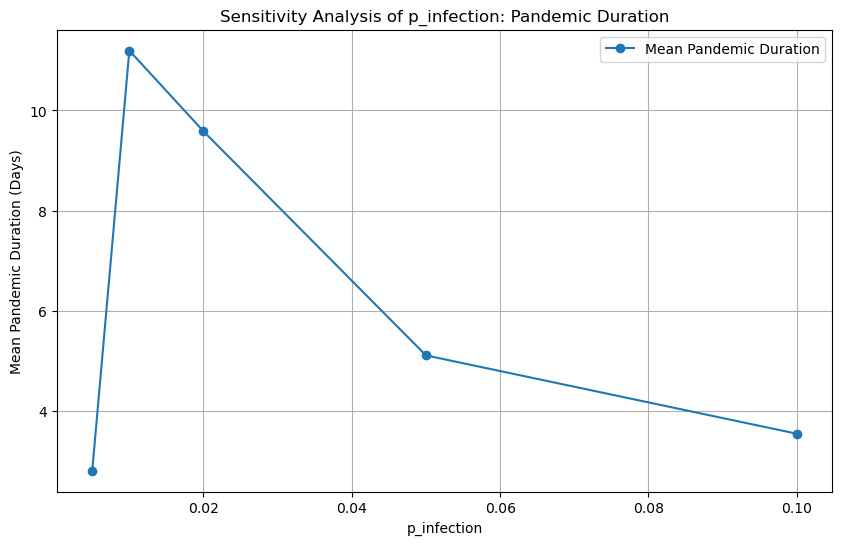

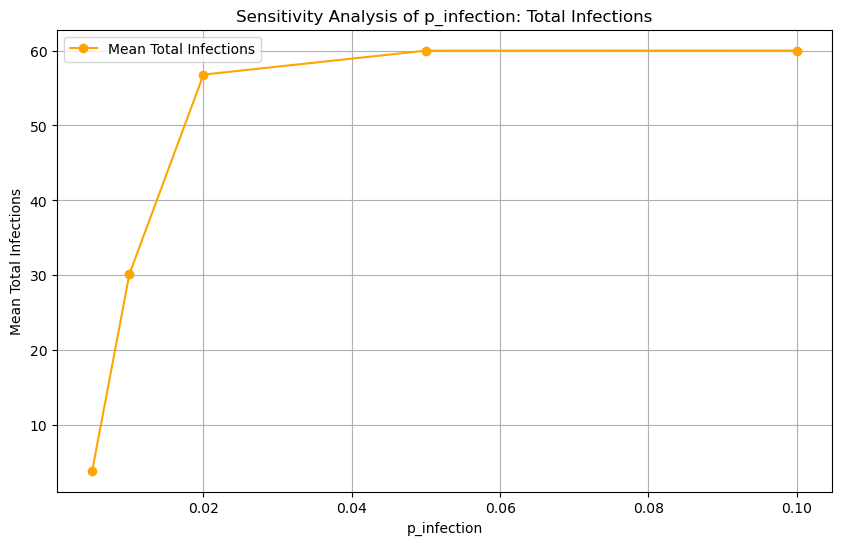

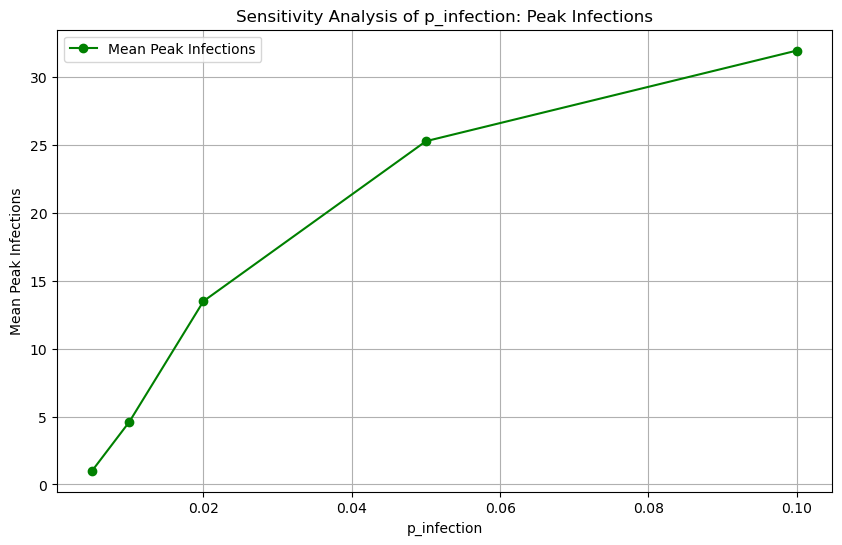


Calculating and visualizing Effective Reproduction Number (Rt)...


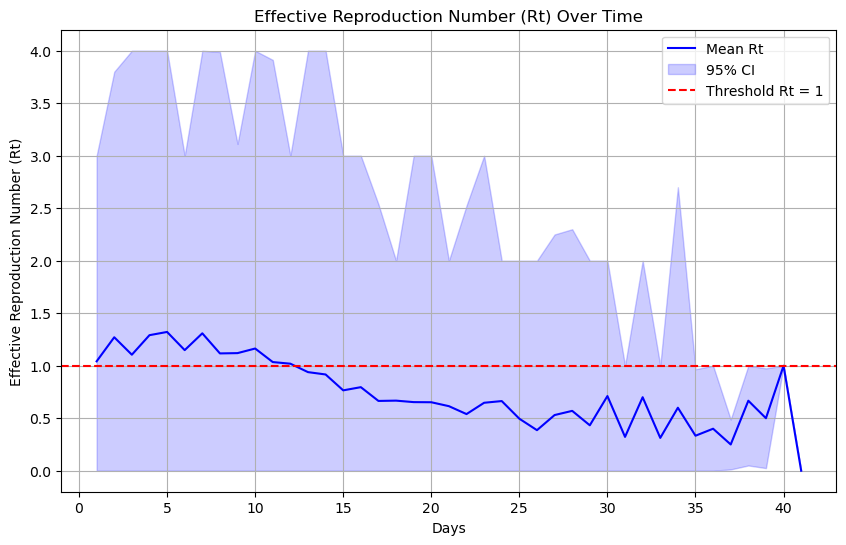


Analyzing the effect of immunization:
Immunization 0.0% - pandemic durations: [0, 19, 4, 16, 3]


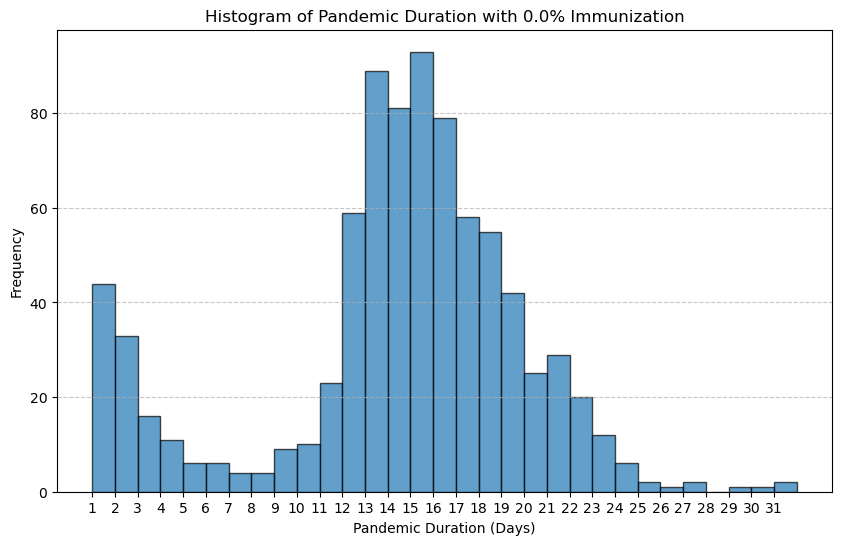

With 0.0% immunization, the pandemic lasted an average of 11.41 days.
Immunization 50.0% - pandemic durations: [0, 0, 0, 2, 2]


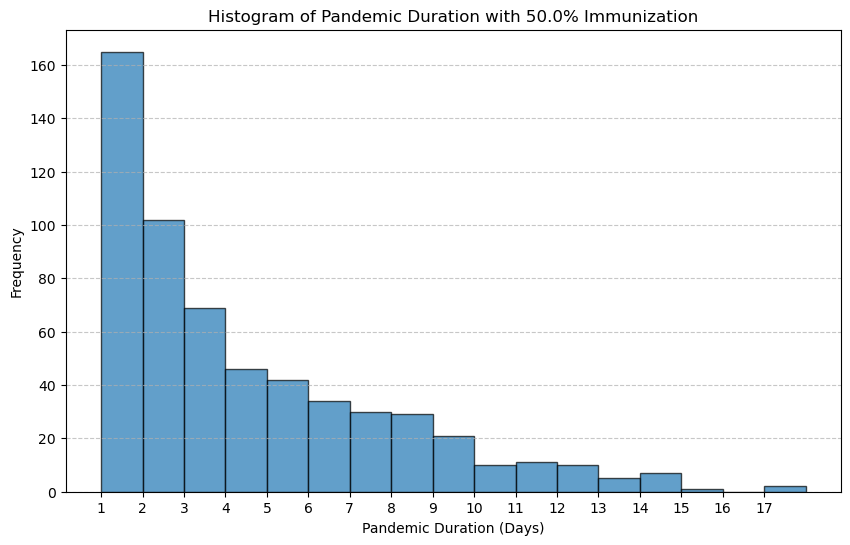

With 50.0% immunization, the pandemic lasted an average of 2.36 days.
Immunization 75.0% - pandemic durations: [0, 0, 2, 0, 0]


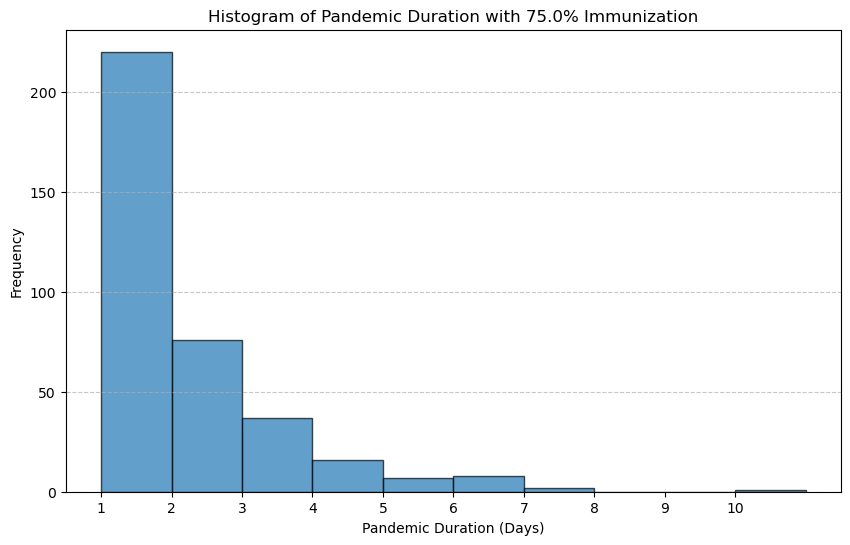

With 75.0% immunization, the pandemic lasted an average of 0.65 days.

Saving simulation results to 'pandemic_results.csv'...
Results saved successfully.
Day 1 Infection Distribution: Mean=0.6, Variance=0.594
Expected infections on Day 1: 0.6
Expected cumulative infections by Day 2: 1.505
Average pandemic duration with 50% immunization: 2.492 days


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import simpledialog
from scipy.stats import binom
import csv

# Default parameters
default_n_kids = 60
default_p_infection = 0.01
default_infectious_days = 3
default_simulations = 1000

# User configuration function
def get_user_inputs():
    """
    Prompt the user for simulation parameters using a simple GUI.
    """
    root = tk.Tk()
    root.withdraw()  # Hide the tkinter root window
    n_kids = simpledialog.askinteger("Input", "Enter the number of kids (excluding Tommy):", initialvalue=default_n_kids)
    p_infection = simpledialog.askfloat("Input", "Enter the probability of infection per contact per day:", initialvalue=default_p_infection)
    infectious_days = simpledialog.askinteger("Input", "Enter the number of infectious days:", initialvalue=default_infectious_days)
    simulations = simpledialog.askinteger("Input", "Enter the number of simulations to run:", initialvalue=default_simulations)
    return n_kids, p_infection, infectious_days, simulations

# Simulation functions
def simulate_pandemic(n_kids, p_infection, infectious_days, simulations):
    """
    Simulate the pandemic spread among kids starting with Tommy as patient zero.
    """
    all_daily_infections = []
    all_day1_infections = []

    for _ in range(simulations):
        infected = np.append(np.zeros(n_kids, dtype=bool), True)  # Tommy starts infected
        infectious = np.append(np.zeros(n_kids, dtype=int), infectious_days)
        daily_infections = []

        while infectious.sum() > 0:
            new_infections = np.zeros(len(infected), dtype=int)
            infectious_indices = np.where(infectious > 0)[0]

            for i in infectious_indices:
                susceptible_indices = np.where(~infected)[0]
                infection_probs = np.random.rand(len(susceptible_indices)) < p_infection
                new_cases = susceptible_indices[infection_probs]

                infected[new_cases] = True
                infectious[new_cases] = infectious_days
                new_infections[new_cases] = 1

                infectious[i] -= 1

            daily_infections.append(new_infections.sum())

        all_daily_infections.append(daily_infections)
        all_day1_infections.append(daily_infections[0] if daily_infections else 0)

    max_days = max(len(sim) for sim in all_daily_infections)
    padded_infections = [sim + [0] * (max_days - len(sim)) for sim in all_daily_infections]
    return np.array(padded_infections), all_day1_infections


def compute_effective_reproduction_number(daily_infections_matrix):
    """
    Compute the Effective Reproduction Number (Rt) for each day during the pandemic.
    
    Parameters:
    daily_infections_matrix: 2D NumPy array where each row represents daily infections for one simulation.

    Returns:
    A 2D NumPy array where each row contains the Rt values for each day in a simulation.
    """
    # Determine the number of simulations and maximum days
    num_simulations, max_days = daily_infections_matrix.shape
    
    # Initialize an array to store Rt values
    Rt_matrix = np.zeros_like(daily_infections_matrix, dtype=float)
    
    for sim_idx in range(num_simulations):
        for day in range(max_days):
            if day == 0:  # Rt is undefined for the first day, as no kids were infectious before Day 1
                Rt_matrix[sim_idx, day] = np.nan
            else:
                # Calculate the number of infectious kids on the previous day
                infectious_kids = daily_infections_matrix[sim_idx, day - 1]
                if infectious_kids > 0:
                    Rt_matrix[sim_idx, day] = daily_infections_matrix[sim_idx, day] / infectious_kids
                else:
                    Rt_matrix[sim_idx, day] = np.nan  # No infectious kids, Rt is undefined
    
    return Rt_matrix

def sensitivity_analysis(
    parameter_name, parameter_values, n_kids=60, p_infection=0.01, infectious_days=3, simulations=1000
):
    """
    Conduct a sensitivity analysis on the specified parameter while keeping others constant.

    Parameters:
    parameter_name (str): The parameter to vary (e.g., "p_infection", "n_kids", "infectious_days").
    parameter_values (list): A list of values for the parameter to test.
    n_kids (int): Number of kids excluding Tommy.
    p_infection (float): Probability of infection per contact per day.
    infectious_days (int): Number of infectious days for each infected kid.
    simulations (int): Number of simulations to run.

    Returns:
    dict: A dictionary containing results for each parameter value.
    """
    results = {}

    for value in parameter_values:
        print(f"Testing {parameter_name} = {value}...")
        if parameter_name == "n_kids":
            current_results, _ = simulate_pandemic(value, p_infection, infectious_days, simulations)
        elif parameter_name == "p_infection":
            current_results, _ = simulate_pandemic(n_kids, value, infectious_days, simulations)
        elif parameter_name == "infectious_days":
            current_results, _ = simulate_pandemic(n_kids, p_infection, value, simulations)
        else:
            raise ValueError("Invalid parameter name. Choose from 'n_kids', 'p_infection', or 'infectious_days'.")

        # Calculate summary statistics
        pandemic_durations = [len([day for day in sim if day > 0]) for sim in current_results]
        total_infections = current_results.sum(axis=1)
        peak_infections = current_results.max(axis=1)

        results[value] = {
            "mean_duration": np.mean(pandemic_durations),
            "duration_CI": compute_confidence_interval(pandemic_durations),
            "mean_total_infections": np.mean(total_infections),
            "total_infections_CI": compute_confidence_interval(total_infections),
            "mean_peak_infections": np.mean(peak_infections),
            "peak_infections_CI": compute_confidence_interval(peak_infections),
        }

    return results

def simulate_with_immunization(n_kids, p_infection, infectious_days, immunization_prob, simulations):
    """
    Simulate the pandemic with a given immunization probability.
    """
    all_daily_infections = []

    for _ in range(simulations):
        immunized = np.append(np.random.rand(n_kids) < immunization_prob, False)  # Tommy is never immunized
        infected = np.append(np.zeros(n_kids, dtype=bool), True)  # Tommy starts infected
        infectious = np.append(np.zeros(n_kids, dtype=int), infectious_days)
        daily_infections = []

        while infectious.sum() > 0:
            new_infections = np.zeros(len(infected), dtype=int)
            infectious_indices = np.where(infectious > 0)[0]

            for i in infectious_indices:
                susceptible_indices = np.where(~infected & ~immunized)[0]
                infection_probs = np.random.rand(len(susceptible_indices)) < p_infection
                new_cases = susceptible_indices[infection_probs]

                infected[new_cases] = True
                infectious[new_cases] = infectious_days
                new_infections[new_cases] = 1

                infectious[i] -= 1

            daily_infections.append(new_infections.sum())

        all_daily_infections.append(daily_infections)

    max_days = max(len(sim) for sim in all_daily_infections)
    padded_infections = [sim + [0] * (max_days - len(sim)) for sim in all_daily_infections]
    return np.array(padded_infections)

# Optimization 
def parallel_simulation(num_processes=4, **kwargs):
    """
    Run pandemic simulations in parallel using multiple processors.
    
    Parameters:
    num_processes: Number of processes to run in parallel
    kwargs: Additional parameters for the pandemic simulation
    """
    with mp.Pool(processes=num_processes) as pool:
        results = pool.map(simulate_pandemic, [kwargs for _ in range(num_processes)])
    return results

# Confidence Intervals
def compute_confidence_interval(data, confidence=0.95):
    """
    Compute the confidence interval for the mean of the data.
    
    Parameters:
    data: The dataset for which the confidence interval is computed
    confidence: Confidence level
    """
    mean = np.mean(data)
    se = np.std(data) / np.sqrt(len(data))
    h = se * 1.96  # 95% confidence interval multiplier
    return mean, mean - h, mean + h

def compute_daily_confidence_intervals(daily_infections_matrix, confidence=0.95):
    """
    Compute the confidence intervals for the expected number of infected kids per day.
    
    Parameters:
    daily_infections_matrix: Matrix where each row represents daily infections for one simulation
    confidence: Confidence level
    
    Returns:
    A list of tuples, each containing the mean and confidence interval for each day
    """
    daily_conf_intervals = []
    for day in range(daily_infections_matrix.shape[1]):
        day_data = daily_infections_matrix[:, day]
        mean, lower, upper = compute_confidence_interval(day_data, confidence)
        daily_conf_intervals.append((mean, lower, upper))
    return daily_conf_intervals


class PandemicSimulation:
    def __init__(self, n_kids=default_n_kids, p_infection=default_p_infection, infectious_days=default_infectious_days):
        self.n_kids = n_kids
        self.p_infection = p_infection
        self.infectious_days = infectious_days

    def run_simulation(self, simulations=default_simulations):
        return simulate_pandemic(self.n_kids, self.p_infection, self.infectious_days, simulations)

    def run_with_immunization(self, immunization_prob=0.5, simulations=default_simulations):
        return simulate_with_immunization(self.n_kids, self.p_infection, self.infectious_days, immunization_prob, simulations)

    def estimate_r0(self, daily_infections_matrix):
        """
        Estimate the basic reproduction number (R0) from the simulation data.
        
        Parameters:
        daily_infections_matrix: Matrix where each row represents daily infections for one simulation
        
        Returns:
        Estimated R0 value
        """
        total_new_infections = daily_infections_matrix[:, 0].sum()  # Total infections caused by Tommy on Day 1
        return total_new_infections / self.n_kids

# Validation functions
def validate_day1_infections(day1_infections, n_kids, p_infection):
    """
    Validate Day 1 infections against theoretical Binomial distribution.
    """
    theoretical_mean = n_kids * p_infection
    theoretical_variance = n_kids * p_infection * (1 - p_infection)
    simulated_mean = np.mean(day1_infections)
    simulated_variance = np.var(day1_infections)
    print(f"Validation of Day 1 Infections:")
    print(f"Theoretical Mean: {theoretical_mean:.2f}, Simulated Mean: {simulated_mean:.2f}")
    print(f"Theoretical Variance: {theoretical_variance:.2f}, Simulated Variance: {simulated_variance:.2f}")

def validate_cumulative_infections(day2_infections, n_kids, p_infection):
    """
    Validate cumulative infections by Day 2 against theoretical expectations.
    """
    day1_expected = n_kids * p_infection
    day2_expected = day1_expected * (n_kids - 1) * p_infection
    theoretical_total = day1_expected + day2_expected
    simulated_mean = np.mean(day2_infections)
    print(f"Validation of Cumulative Infections by Day 2:")
    print(f"Theoretical Total Infections by Day 2: {theoretical_total:.2f}, Simulated: {simulated_mean:.2f}")

# Visualization functions
def plot_pandemic_curve(daily_infections_matrix):
    """
    Plot the average number of daily infections over time.
    """
    avg_infections = daily_infections_matrix.mean(axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(avg_infections, label="Average Daily Infections")
    plt.xlabel("Days")
    plt.ylabel("Number of Infections")
    plt.title("Average Daily Infections Over Time")
    plt.legend()
    plt.show()
    
def plot_pandemic_duration_histogram(pandemic_durations, title):
    """
    Plot a histogram of pandemic durations.

    Parameters:
    pandemic_durations (list or array): List of pandemic durations (number of days with infections).
    title (str): Title of the histogram.

    Returns:
    float: The average duration of the pandemic, or None if no valid durations exist.
    """
    if len(pandemic_durations) == 0 or all(duration == 0 for duration in pandemic_durations):
        print("No valid pandemic durations to plot.")
        return None

    plt.figure(figsize=(10, 6))
    plt.hist(pandemic_durations, bins=range(1, max(pandemic_durations) + 2), alpha=0.7, edgecolor="black")
    plt.xlabel("Pandemic Duration (Days)")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(range(1, max(pandemic_durations) + 1))
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    return np.mean(pandemic_durations)

def plot_effective_reproduction_number(Rt_matrix):
    """
    Plot the Effective Reproduction Number (Rt) over time with confidence intervals.

    Parameters:
    Rt_matrix: 2D NumPy array where each row contains the Rt values for each day in a simulation.
    """
    # Filter out columns with all NaN values
    valid_days = ~np.isnan(Rt_matrix).all(axis=0)

    # Compute mean and confidence intervals only for valid days
    mean_Rt = np.nanmean(Rt_matrix[:, valid_days], axis=0)
    lower_CI = np.nanpercentile(Rt_matrix[:, valid_days], 2.5, axis=0)
    upper_CI = np.nanpercentile(Rt_matrix[:, valid_days], 97.5, axis=0)

    days = np.arange(1, len(mean_Rt) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(days, mean_Rt, label="Mean Rt", color="blue")
    plt.fill_between(days, lower_CI, upper_CI, color="blue", alpha=0.2, label="95% CI")
    plt.axhline(y=1, color="red", linestyle="--", label="Threshold Rt = 1")
    plt.xlabel("Days")
    plt.ylabel("Effective Reproduction Number (Rt)")
    plt.title("Effective Reproduction Number (Rt) Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_sensitivity_analysis(results, parameter_name):
    """
    Visualize the results of the sensitivity analysis.

    Parameters:
    results (dict): Results dictionary returned by `sensitivity_analysis`.
    parameter_name (str): The parameter being varied.
    """
    parameter_values = list(results.keys())
    mean_durations = [results[val]["mean_duration"] for val in parameter_values]
    mean_total_infections = [results[val]["mean_total_infections"] for val in parameter_values]
    mean_peak_infections = [results[val]["mean_peak_infections"] for val in parameter_values]

    # Plot mean pandemic duration
    plt.figure(figsize=(10, 6))
    plt.plot(parameter_values, mean_durations, marker="o", label="Mean Pandemic Duration")
    plt.xlabel(parameter_name)
    plt.ylabel("Mean Pandemic Duration (Days)")
    plt.title(f"Sensitivity Analysis of {parameter_name}: Pandemic Duration")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot mean total infections
    plt.figure(figsize=(10, 6))
    plt.plot(parameter_values, mean_total_infections, marker="o", color="orange", label="Mean Total Infections")
    plt.xlabel(parameter_name)
    plt.ylabel("Mean Total Infections")
    plt.title(f"Sensitivity Analysis of {parameter_name}: Total Infections")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot mean peak infections
    plt.figure(figsize=(10, 6))
    plt.plot(parameter_values, mean_peak_infections, marker="o", color="green", label="Mean Peak Infections")
    plt.xlabel(parameter_name)
    plt.ylabel("Mean Peak Infections")
    plt.title(f"Sensitivity Analysis of {parameter_name}: Peak Infections")
    plt.grid(True)
    plt.legend()
    plt.show()
    
# Analyze immunization effects    
def analyze_immunization_effects_with_theory(n_kids, p_infection, infectious_days, simulations):
    """
    Analyze the effects of different immunization levels on the pandemic, 
    including theoretical values.

    Parameters:
    n_kids (int): Number of kids excluding Tommy.
    p_infection (float): Probability of infection per contact per day.
    infectious_days (int): Number of infectious days for each infected kid.
    simulations (int): Number of simulations to run.
    """
    # Immunization levels to test
    immunization_levels = [0.0, 0.5, 0.75]  # No immunization, 50%, and 75%

    for level in immunization_levels:
        # Simulate pandemic with the given immunization level
        results = simulate_with_immunization(n_kids, p_infection, infectious_days, level, simulations)
        
        # Compute pandemic durations (number of days with infections > 0 for each simulation)
        pandemic_durations = np.sum(results > 0, axis=1)

        # Theoretical susceptible population
        n_susceptible = int(n_kids * (1 - level))
        theoretical_day1_infections = n_susceptible * p_infection

        print(f"\nImmunization Level: {level*100:.1f}%")
        print(f"Theoretical Day 1 Infections: {theoretical_day1_infections:.2f}")

        # Compute average and plot histogram of pandemic durations
        if len(pandemic_durations) > 0 and not all(d == 0 for d in pandemic_durations):
            avg_duration = plot_pandemic_duration_histogram(
                pandemic_durations, f"Histogram of Pandemic Duration with {level*100:.1f}% Immunization"
            )
            print(f"Simulated Pandemic Duration (Average): {avg_duration:.2f} days")
        else:
            print("No pandemic spread.")
            
# Main execution
if __name__ == "__main__":
    print("ISYE_6644 Pandemic Flu Spread Simulation")
    
    
    # Get user inputs for simulation
    n_kids, p_infection, infectious_days, simulations = get_user_inputs()
    
    # Simulate pandemic without immunization
    results, day1_infections = simulate_pandemic(n_kids, p_infection, infectious_days, simulations)
    print("\nSimulation completed without immunization.")
    
    # Calculate and print confidence interval for pandemic duration
    pandemic_durations = [len([day for day in sim if day > 0]) for sim in results]
    mean, lower, upper = compute_confidence_interval(pandemic_durations)
    print(f"Pandemic Duration: Mean = {mean:.2f}, 95% Confidence Interval = ({lower:.2f}, {upper:.2f})")
    
    # Plot histogram of pandemic durations
    plot_pandemic_histogram(pandemic_durations, title='Histogram of Pandemic Duration')

    # I calculate and print daily confidence intervals
    daily_conf_intervals = compute_daily_confidence_intervals(results)
    for day, (mean, lower, upper) in enumerate(daily_conf_intervals):
        print(f"Day {day + 1}: Mean Infections = {mean:.2f}, 95% Confidence Interval = ({lower:.2f}, {upper:.2f})")

    # Estimate and print R0
    simulation = PandemicSimulation(n_kids, p_infection, infectious_days)
    r0_estimate = simulation.estimate_r0(results)
    print(f"Estimated Basic Reproduction Number (R0): {r0_estimate:.2f}")
    
    # Validate Day 1 infections
    validate_day1_infections(day1_infections, n_kids, p_infection)

    # Validate cumulative infections by Day 2
    day2_infections = results[:, :2].sum(axis=1)
    validate_cumulative_infections(day2_infections, n_kids, p_infection)
    
    # Plot pandemic curve
    plot_pandemic_curve(results)
    
    # Sensitivity Analysis
    print("\nConducting sensitivity analysis for p_infection...")
    parameter_values = [0.005, 0.01, 0.02, 0.05, 0.1]  
    sensitivity_results = sensitivity_analysis("p_infection", parameter_values, n_kids=n_kids, infectious_days=infectious_days, simulations=500)
    plot_sensitivity_analysis(sensitivity_results, "p_infection")
    
    # Calculate and visualize Rt
    print("\nCalculating and visualizing Effective Reproduction Number (Rt)...")
    Rt_matrix = compute_effective_reproduction_number(results)
    plot_effective_reproduction_number(Rt_matrix)

    # Analyze the effect of immunization
    print("\nAnalyzing the effect of immunization:")
    analyze_immunization_effects(n_kids, p_infection, infectious_days, simulations)

    # Save results to CSV
    print("\nSaving simulation results to 'pandemic_results.csv'...")
    with open("pandemic_results.csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Day_" + str(i) for i in range(results.shape[1])])
        writer.writerows(results)
    print("Results saved successfully.")
    

# Question (a): Distribution of kids Tommy infects on Day 1
day1_distribution = binom(n=n_kids, p=p_infection)
print(f"Day 1 Infection Distribution: Mean={day1_distribution.mean()}, Variance={day1_distribution.var()}")

# Question (b): Expected number of infections on Day 1
expected_infections_day1 = day1_distribution.mean()
print(f"Expected infections on Day 1: {expected_infections_day1}")

# Question (c): Cumulative infections by Day 2
# Simulating the cumulative infections for multiple trials and reporting the mean
day2_cumulative_infections = np.mean(np.sum(results[:, :2], axis=1))
print(f"Expected cumulative infections by Day 2: {day2_cumulative_infections}")

# Question (e): Impact of immunization
immunization_prob = 0.5  
results_with_immunization = simulate_with_immunization(n_kids, p_infection, infectious_days, immunization_prob, simulations)
pandemic_durations_immunization = np.sum(results_with_immunization > 0, axis=1)
print(f"Average pandemic duration with 50% immunization: {np.mean(pandemic_durations_immunization)} days")


Further Validation Analysis

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def validate_extended_pandemic(simulated_daily_infections, n_kids, p_infection, max_days=10):
    """
    Validate the extended simulation results against theoretical expectations over multiple days.

    Parameters:
    simulated_daily_infections (np.array): 2D array where rows are simulations and columns are daily infections.
    n_kids (int): Number of kids excluding the initially infected individual.
    p_infection (float): Probability of infection per contact per day.
    max_days (int): Number of days to validate.

    Returns:
    pd.DataFrame: DataFrame containing theoretical vs simulated means and variances for each day.
    """
    results = []

    for day in range(1, max_days + 1):
        # Calculate theoretical mean and variance
        theoretical_mean = n_kids * (p_infection ** day)
        theoretical_variance = theoretical_mean * (1 - p_infection ** day)

        # Calculate simulated mean and variance
        simulated_mean = np.mean(simulated_daily_infections[:, day - 1])
        simulated_variance = np.var(simulated_daily_infections[:, day - 1])

        # Collect results
        results.append({
            "Day": day,
            "Theoretical Mean": theoretical_mean,
            "Simulated Mean": simulated_mean,
            "Theoretical Variance": theoretical_variance,
            "Simulated Variance": simulated_variance,
        })

    # Convert results to DataFrame
    validation_df = pd.DataFrame(results)
    return validation_df


# Example simulation to validate
# simulated daily infections for 100 simulations and 10 days
np.random.seed(42)
n_days = 10
simulated_daily_infections = np.random.poisson(n_kids * p_infection, size=(simulations, n_days))

# Perform validation
extended_validation_results = validate_extended_pandemic(simulated_daily_infections, n_kids, p_infection, max_days=n_days)

print(extended_validation_results)




   Day  Theoretical Mean  Simulated Mean  Theoretical Variance  \
0    1      6.000000e-01           0.540          5.940000e-01   
1    2      6.000000e-03           0.635          5.999400e-03   
2    3      6.000000e-05           0.597          5.999994e-05   
3    4      6.000000e-07           0.578          6.000000e-07   
4    5      6.000000e-09           0.596          6.000000e-09   
5    6      6.000000e-11           0.563          6.000000e-11   
6    7      6.000000e-13           0.613          6.000000e-13   
7    8      6.000000e-15           0.600          6.000000e-15   
8    9      6.000000e-17           0.566          6.000000e-17   
9   10      6.000000e-19           0.604          6.000000e-19   

   Simulated Variance  
0            0.540400  
1            0.641775  
2            0.622591  
3            0.561916  
4            0.600784  
5            0.528031  
6            0.651231  
7            0.558000  
8            0.569644  
9            0.573184  


Real World Data for Comparsion

In [8]:
# Load the empirical data
empirical_data = pd.read_csv('/Users/winnietaiwo/Downloads/summary_usa.csv')

# Display the data
print(empirical_data.head())

# Define the benchmarking function
def benchmark_simulation_with_empirical(simulated_results, empirical_data, state_column="State/Territory"):
    """
    Benchmark simulated results with empirical data.

    Parameters:
    simulated_results (pd.DataFrame): Simulation results with columns for states and metrics.
    empirical_data (pd.DataFrame): Empirical data with columns for states and metrics.
    state_column (str): Column name representing the states/territories.

    Returns:
    pd.DataFrame: A DataFrame comparing simulated and empirical data.
    """
    # Merging the simulated and empirical data on the state column
    comparison_df = simulated_results.merge(empirical_data, on=state_column, how="inner")

    # Calculating the absolute and percentage differences
    for column in ["State reported confirmed cases", "State reported hospitalization", "Confirmed deaths"]:
        if column in comparison_df.columns:
            simulated_col = f"Simulated {column}"
            diff_col = f"Difference ({column})"
            pct_diff_col = f"Percentage Difference ({column})"

            # Computing differences
            comparison_df[diff_col] = comparison_df[column] - comparison_df[simulated_col]
            comparison_df[pct_diff_col] = (
                (comparison_df[diff_col] / comparison_df[column]) * 100
            ).round(2)

    return comparison_df

# Simulated data for testing
simulated_results = pd.DataFrame({
    "State/Territory": ["Alabama", "Alaska", "Arizona", "Arkansas", "California"],
    "Simulated State reported confirmed cases": [2400, 1500, 8700, 200, 10500],
    "Simulated State reported hospitalization": [None, 20, 1900, None, 8600],
    "Simulated Confirmed deaths": [18, 12, 150, 30, 650]
})

# Display the results in the console
print(benchmark_results)




  State/Territory  State reported confirmed cases  \
0         Alabama                            2453   
1          Alaska                            1563   
2         Arizona                            8726   
3        Arkansas                             154   
4      California                           10545   

   State reported hospitalization  Confirmed deaths  
0                             NaN                19  
1                            18.0                13  
2                          1897.0               152  
3                             NaN                32  
4                          8589.0               657  
  State/Territory  Simulated State reported confirmed cases  \
0         Alabama                                      2400   
1          Alaska                                      1500   
2         Arizona                                      8700   
3        Arkansas                                       200   
4      California                         